<a href="https://colab.research.google.com/github/Yash-911/HAR-Analysis/blob/Master/HAR_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# -*- coding: utf-8 -*-
"""HAR Dataset Complete Analysis.ipynb"""

# Cell 1: Setup and Import Libraries
"""
# Human Activity Recognition (HAR) Dataset Analysis
A comprehensive analysis and preprocessing pipeline for the HAR dataset.
"""

# Install required packages
!pip install pandas numpy matplotlib seaborn scikit-learn plotly tabulate

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from scipy import stats
import plotly.express as px
import plotly.graph_objects as go
from scipy.signal import butter, filtfilt
import os
from tabulate import tabulate

# Configure display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Set plotting style
plt.style.use('seaborn')
sns.set_palette("husl")

<ipython-input-13-66f96568a885>:34: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [ ]:
# Cell 2: Download Dataset
"""## Data Download and Initial Setup"""

# Download and extract dataset if not already present
if not os.path.exists('UCI HAR Dataset'):
    !wget https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip
    !unzip 'UCI HAR Dataset.zip'
    print("Dataset downloaded and extracted successfully!")
else:
    print("Dataset already exists in the directory.")

Dataset already exists in the directory.


In [ ]:
# Cell 3: Data Loading Class
class HARDataLoader:
    """Class for loading and preparing HAR dataset"""

    def __init__(self, data_path='UCI HAR Dataset'):
        self.data_path = data_path
        self.features = None
        self.activities = None

    def load_data(self):
        """Load and prepare the HAR dataset"""
        print("Loading HAR dataset...")

        # Load training data
        X_train = pd.read_csv(f'{self.data_path}/train/X_train.txt',
                             delim_whitespace=True, header=None)
        y_train = pd.read_csv(f'{self.data_path}/train/y_train.txt',
                             names=['activity'], header=None)
        subject_train = pd.read_csv(f'{self.data_path}/train/subject_train.txt',
                                  names=['subject'], header=None)

        # Load test data
        X_test = pd.read_csv(f'{self.data_path}/test/X_test.txt',
                            delim_whitespace=True, header=None)
        y_test = pd.read_csv(f'{self.data_path}/test/y_test.txt',
                            names=['activity'], header=None)
        subject_test = pd.read_csv(f'{self.data_path}/test/subject_test.txt',
                                 names=['subject'], header=None)

        # Load features and activities
        self.features = pd.read_csv(f'{self.data_path}/features.txt',
                                  delim_whitespace=True, header=None,
                                  names=['index', 'feature'])
        self.activities = pd.read_csv(f'{self.data_path}/activity_labels.txt',
                                    delim_whitespace=True, header=None,
                                    names=['index', 'activity'])

        # Set feature names
        X_train.columns = self.features['feature']
        X_test.columns = self.features['feature']

        # # Map activities to names
        # activity_map = dict(self.activities.values)
        # y_train['activity'] = y_train['activity'].map(activity_map)
        # y_test['activity'] = y_test['activity'].map(activity_map)
        # Map activities to names
        activity_map = dict(self.activities.values)
        # Convert activity names to numeric labels
        y_train['activity'] = y_train['activity'].map(activity_map).astype('category').cat.codes
        y_test['activity'] = y_test['activity'].map(activity_map).astype('category').cat.codes

        print("\nDataset Loading Complete!")
        print(f"Training set shape: {X_train.shape}")
        print(f"Testing set shape: {X_test.shape}")
        print("\nFeature Types:")
        print(f"Time domain features: {len([f for f in self.features['feature'] if f.startswith('t')])}")
        print(f"Frequency domain features: {len([f for f in self.features['feature'] if f.startswith('f')])}")

        # Display activity distribution
        print("\nActivity Distribution (Training Set):")
        activity_dist = y_train['activity'].value_counts()
        for activity, count in activity_dist.items():
            print(f"{activity}: {count:,} samples ({count/len(y_train)*100:.1f}%)")

        return X_train, X_test, y_train, y_test, subject_train, subject_test


In [ ]:
# Cell 4: Load Data
# Initialize data loader and load dataset
loader = HARDataLoader()
X_train, X_test, y_train, y_test, subject_train, subject_test = loader.load_data()

# Display sample of the data
print("\nSample of Training Data:")
print(X_train.head().to_markdown())

print("\nFeature Names (first 10):")
print(loader.features['feature'].head(10).to_markdown())

print("\nActivity Labels:")
print(loader.activities.to_markdown())

<ipython-input-15-32512a925b54>:15: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X_train = pd.read_csv(f'{self.data_path}/train/X_train.txt',


Loading HAR dataset...


<ipython-input-15-32512a925b54>:23: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X_test = pd.read_csv(f'{self.data_path}/test/X_test.txt',
<ipython-input-15-32512a925b54>:31: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  self.features = pd.read_csv(f'{self.data_path}/features.txt',
<ipython-input-15-32512a925b54>:34: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  self.activities = pd.read_csv(f'{self.data_path}/activity_labels.txt',



Dataset Loading Complete!
Training set shape: (7352, 561)
Testing set shape: (2947, 561)

Feature Types:
Time domain features: 265
Frequency domain features: 289

Activity Distribution (Training Set):
0: 1,407 samples (19.1%)
2: 1,374 samples (18.7%)
1: 1,286 samples (17.5%)
3: 1,226 samples (16.7%)
5: 1,073 samples (14.6%)
4: 986 samples (13.4%)

Sample of Training Data:
|    |   tBodyAcc-mean()-X |   tBodyAcc-mean()-Y |   tBodyAcc-mean()-Z |   tBodyAcc-std()-X |   tBodyAcc-std()-Y |   tBodyAcc-std()-Z |   tBodyAcc-mad()-X |   tBodyAcc-mad()-Y |   tBodyAcc-mad()-Z |   tBodyAcc-max()-X |   tBodyAcc-max()-Y |   tBodyAcc-max()-Z |   tBodyAcc-min()-X |   tBodyAcc-min()-Y |   tBodyAcc-min()-Z |   tBodyAcc-sma() |   tBodyAcc-energy()-X |   tBodyAcc-energy()-Y |   tBodyAcc-energy()-Z |   tBodyAcc-iqr()-X |   tBodyAcc-iqr()-Y |   tBodyAcc-iqr()-Z |   tBodyAcc-entropy()-X |   tBodyAcc-entropy()-Y |   tBodyAcc-entropy()-Z |   tBodyAcc-arCoeff()-X,1 |   tBodyAcc-arCoeff()-X,2 |   tBodyAcc-arCoe

In [ ]:
# Cell 5: Preprocessing Class
class HARPreprocessor:
    """Class for preprocessing HAR dataset"""

    def __init__(self, window_size=128, overlap=0.5):
        self.window_size = window_size
        self.overlap = overlap
        self.scaler = StandardScaler()
        self.pca = None
        self.label_encoder = LabelEncoder()

    def clean_data(self, X_train, X_test):
        """Clean data by handling outliers and missing values"""
        print("\n=== Data Cleaning ===")

        # Check for missing values
        print("Checking for missing values...")
        train_missing = X_train.isnull().sum().sum()
        test_missing = X_test.isnull().sum().sum()
        print(f"Training set missing values: {train_missing}")
        print(f"Testing set missing values: {test_missing}")

        # Handle outliers using IQR method
        print("\nHandling outliers...")
        def remove_iqr_outliers(data):
            Q1 = data.quantile(0.25)
            Q3 = data.quantile(0.75)
            IQR = Q3 - Q1
            outlier_mask = ~((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))).any(axis=1)
            return data[outlier_mask], outlier_mask

        X_train_clean, train_mask = remove_iqr_outliers(X_train)
        X_test_clean, test_mask = remove_iqr_outliers(X_test)

        print(f"Removed {len(X_train) - len(X_train_clean)} outliers from training set")
        print(f"Removed {len(X_test) - len(X_test_clean)} outliers from test set")

        # Visualize before and after outlier removal
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 2, 1)
        sns.boxplot(data=X_train.iloc[:, :5])
        plt.title('Before Outlier Removal')
        plt.xticks(rotation=45)

        plt.subplot(1, 2, 2)
        sns.boxplot(data=X_train_clean.iloc[:, :5])
        plt.title('After Outlier Removal')
        plt.xticks(rotation=45)

        plt.tight_layout()
        plt.show()

        return X_train_clean, X_test_clean, train_mask, test_mask

    def scale_features(self, X_train, X_test):
        """Scale features using StandardScaler"""
        print("\n=== Feature Scaling ===")

        # Scale features
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)

        # Convert back to DataFrame
        X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
        X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

        # Visualize scaling results
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 2, 1)
        sns.histplot(data=X_train.iloc[:, :5], alpha=0.5)
        plt.title('Before Scaling')

        plt.subplot(1, 2, 2)
        sns.histplot(data=X_train_scaled.iloc[:, :5], alpha=0.5)
        plt.title('After Scaling')

        plt.tight_layout()
        plt.show()

        return X_train_scaled, X_test_scaled

    def reduce_dimensions(self, X_train_scaled, X_test_scaled, variance_threshold=0.95):
        """Reduce dimensions using PCA"""
        print("\n=== Dimensionality Reduction ===")

        # Apply PCA
        self.pca = PCA(n_components=variance_threshold, svd_solver='full')
        X_train_pca = self.pca.fit_transform(X_train_scaled)
        X_test_pca = self.pca.transform(X_test_scaled)

        # Print explained variance information
        print(f"Number of components selected: {self.pca.n_components_}")
        print(f"Explained variance ratio: {self.pca.explained_variance_ratio_.sum():.3f}")

        # Plot explained variance ratio
        plt.figure(figsize=(10, 5))
        cumulative_variance = np.cumsum(self.pca.explained_variance_ratio_)
        plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 'bo-')
        plt.axhline(y=variance_threshold, color='r', linestyle='--')
        plt.title('Explained Variance Ratio vs. Number of Components')
        plt.xlabel('Number of Components')
        plt.ylabel('Cumulative Explained Variance Ratio')
        plt.grid(True)
        plt.show()

        return X_train_pca, X_test_pca

    def create_windows(self, X, y):
        """Create sliding windows for time series data"""
        print("\n=== Creating Sliding Windows ===")

        stride = int(self.window_size * (1 - self.overlap))
        n_samples = ((X.shape[0] - self.window_size) // stride) + 1
        n_features = X.shape[1] if len(X.shape) > 1 else 1

        # Initialize arrays for windows and labels
        windows = np.zeros((n_samples, self.window_size, n_features))
        labels = np.zeros(n_samples)

        # Create windows
        for i in range(n_samples):
            start_idx = i * stride
            end_idx = start_idx + self.window_size
            windows[i] = X[start_idx:end_idx]
            labels[i] = stats.mode(y[start_idx:end_idx])[0]

        print(f"Created {n_samples} windows of size {self.window_size}")
        print(f"Window shape: {windows.shape}")

        # Visualize a sample window
        plt.figure(figsize=(12, 4))
        plt.plot(windows[0, :, 0])
        plt.title('Sample Window (First Feature)')
        plt.xlabel('Time Steps')
        plt.ylabel('Signal Value')
        plt.grid(True)
        plt.show()

        return windows, labels


=== Data Cleaning ===
Checking for missing values...
Training set missing values: 0
Testing set missing values: 0

Handling outliers...
Removed 6851 outliers from training set
Removed 2781 outliers from test set


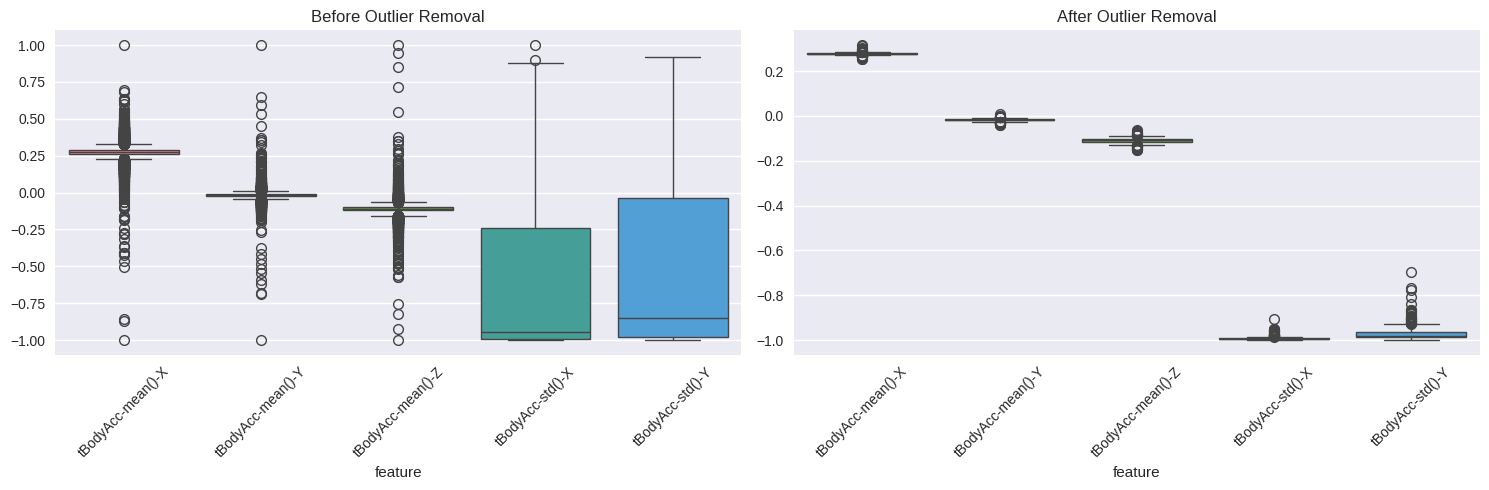


=== Feature Scaling ===


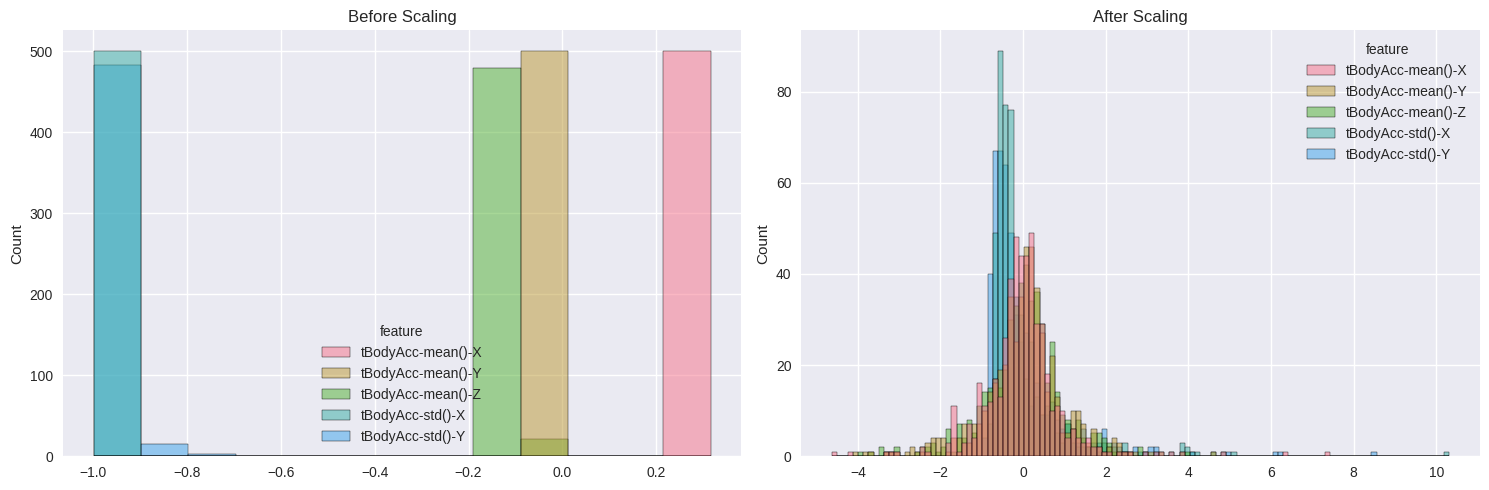


=== Dimensionality Reduction ===
Number of components selected: 88
Explained variance ratio: 0.951


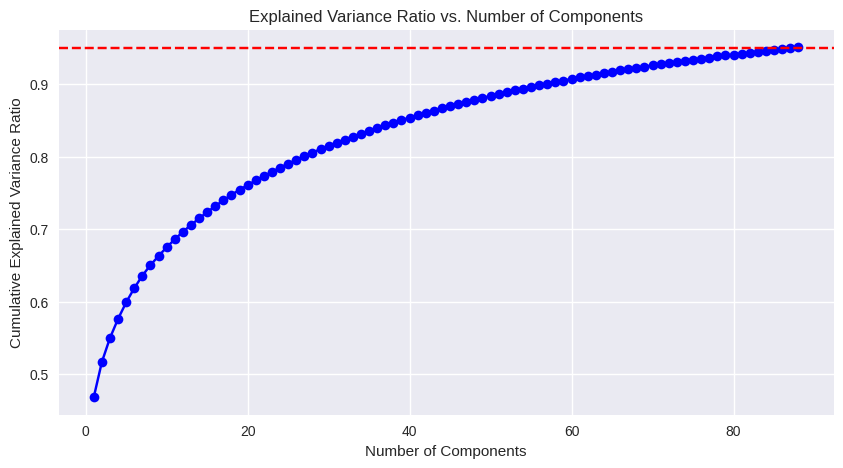


=== Creating Sliding Windows ===
Created 6 windows of size 128
Window shape: (6, 128, 88)


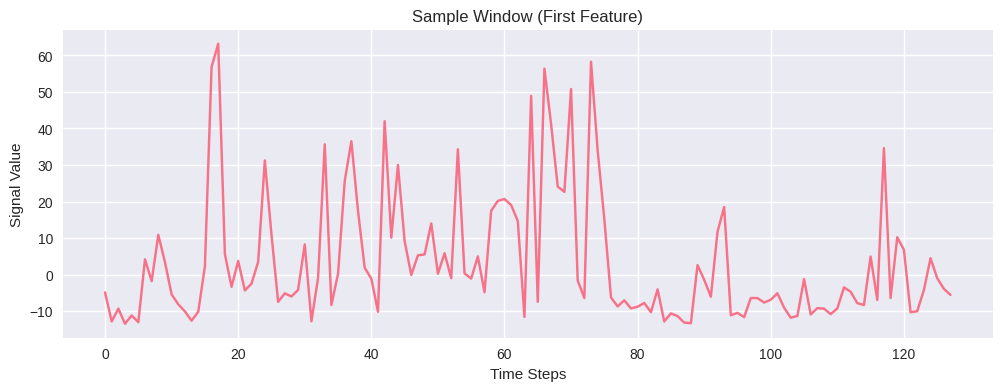


=== Creating Sliding Windows ===
Created 1 windows of size 128
Window shape: (1, 128, 88)


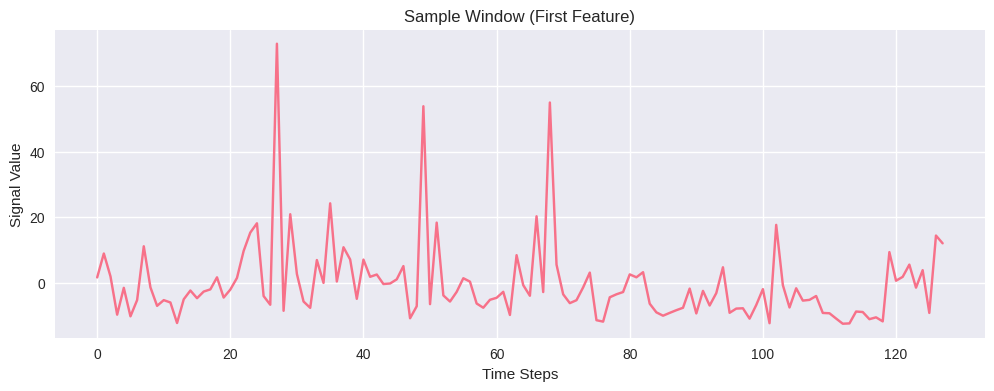


=== Preprocessing Summary ===
Original training samples: 7352
Cleaned training samples: 501
Final training windows: 6
Original features: 561
PCA features: 88

Preprocessing complete!


In [ ]:
# Cell 6: Preprocessing Pipeline Function
def preprocess_har_data(X_train, X_test, y_train, y_test, window_size=128, overlap=0.5):
    """Complete preprocessing pipeline"""

    # Initialize preprocessor
    preprocessor = HARPreprocessor(window_size=window_size, overlap=overlap)

    # Clean data
    X_train_clean, X_test_clean, train_mask, test_mask = preprocessor.clean_data(X_train, X_test)
    y_train_clean = y_train[train_mask]
    y_test_clean = y_test[test_mask]

    # Scale features
    X_train_scaled, X_test_scaled = preprocessor.scale_features(X_train_clean, X_test_clean)

    # Reduce dimensions
    X_train_pca, X_test_pca = preprocessor.reduce_dimensions(X_train_scaled, X_test_scaled)

    # Create windows
    X_train_windows, y_train_windows = preprocessor.create_windows(X_train_pca, y_train_clean['activity'].values)
    X_test_windows, y_test_windows = preprocessor.create_windows(X_test_pca, y_test_clean['activity'].values)

    print("\n=== Preprocessing Summary ===")
    print(f"Original training samples: {len(X_train)}")
    print(f"Cleaned training samples: {len(X_train_clean)}")
    print(f"Final training windows: {len(X_train_windows)}")
    print(f"Original features: {X_train.shape[1]}")
    print(f"PCA features: {X_train_pca.shape[1]}")

    return (X_train_windows, X_test_windows,
            y_train_windows, y_test_windows,
            preprocessor.scaler, preprocessor.pca)

# Cell 7: Execute Preprocessing
# Apply preprocessing pipeline
preprocessed_data = preprocess_har_data(X_train, X_test, y_train, y_test)

# Unpack preprocessed data
(X_train_windows, X_test_windows,
 y_train_windows, y_test_windows,
 scaler, pca) = preprocessed_data

print("\nPreprocessing complete!")

In [ ]:
# Cell 8: Analysis Class
class HARAnalyzer:
    """Class for analyzing HAR dataset patterns and distributions"""

    def __init__(self, raw_data, processed_data):
        self.raw_data = raw_data
        self.processed_data = processed_data

    def visualize_activity_signals(self, window_size=100):
        """Visualize sensor patterns for each activity"""
        print("\n=== Activity Signal Analysis ===")

        signals = {
            'Body Acceleration': 'tBodyAcc-mean()-X',
            'Angular Velocity': 'tBodyGyro-mean()-X',
            'Body Jerk': 'tBodyAccJerk-mean()-X'
        }

        X_train = self.raw_data['X_train']
        y_train = self.raw_data['y_train']

        for activity in y_train['activity'].unique():
            print(f"\nAnalyzing signals for: {activity}")

            plt.figure(figsize=(15, 10))
            activity_mask = y_train['activity'] == activity

            for i, (signal_name, signal) in enumerate(signals.items(), 1):
                plt.subplot(3, 1, i)
                signal_data = X_train[signal][activity_mask][:window_size]

                plt.plot(signal_data.values, linewidth=2, label=signal_name)
                plt.title(f'{signal_name} Pattern for {activity}')
                plt.xlabel('Time Steps')
                plt.ylabel('Signal Value')
                plt.grid(True, alpha=0.3)
                plt.legend()

            plt.tight_layout()
            plt.show()

            # Calculate and display statistics
            stats = pd.DataFrame()
            for signal_name, signal in signals.items():
                signal_data = X_train[signal][activity_mask]
                stats[signal_name] = [
                    signal_data.mean(),
                    signal_data.std(),
                    signal_data.max(),
                    signal_data.min()
                ]
            stats.index = ['Mean', 'Std Dev', 'Max', 'Min']
            print("\nSignal Statistics:")
            print(stats.round(3).to_markdown())

            # Print insights
            print("\nKey Insights:")
            for signal_name in signals.keys():
                std_dev = stats[signal_name]['Std Dev']
                max_val = stats[signal_name]['Max']
                print(f"{signal_name}:")
                print(f"- Variation: {'High' if std_dev > 0.1 else 'Low'} (std_dev: {std_dev:.3f})")
                print(f"- Range: {stats[signal_name]['Max'] - stats[signal_name]['Min']:.3f}")

    def analyze_activity_distribution(self):
      """Analyze and visualize activity distribution"""
      print("\n=== Activity Distribution Analysis ===")

      y_train = self.raw_data['y_train']
      y_test = self.raw_data['y_test']

      # Create distribution DataFrame
      train_dist = y_train['activity'].value_counts().reset_index()
      train_dist.columns = ['Activity', 'Training Samples']

      test_dist = y_test['activity'].value_counts().reset_index()
      test_dist.columns = ['Activity', 'Testing Samples']

      # Merge train and test distributions
      dist_df = pd.merge(train_dist, test_dist, on='Activity')

      # Calculate additional metrics
      dist_df['Total'] = dist_df['Training Samples'] + dist_df['Testing Samples']
      dist_df['Training %'] = (dist_df['Training Samples'] / len(y_train) * 100).round(2)
      dist_df['Testing %'] = (dist_df['Testing Samples'] / len(y_test) * 100).round(2)

      # Display distribution table
      print("\nActivity Distribution:")
      print(dist_df.to_markdown())

      # Create interactive distribution plot
      fig = go.Figure()

      # Add training distribution
      fig.add_trace(go.Bar(
          name='Training',
          x=dist_df['Activity'],
          y=dist_df['Training %'],
          text=dist_df['Training %'].round(1).astype(str) + '%',
          textposition='auto',
      ))

      # Add testing distribution
      fig.add_trace(go.Bar(
          name='Testing',
          x=dist_df['Activity'],
          y=dist_df['Testing %'],
          text=dist_df['Testing %'].round(1).astype(str) + '%',
          textposition='auto',
      ))

      fig.update_layout(
          title='Activity Distribution in Training and Test Sets',
          xaxis_title='Activity',
          yaxis_title='Percentage (%)',
          barmode='group',
          showlegend=True
      )

      fig.show()

      # Print insights
      print("\nKey Distribution Insights:")
      print(f"1. Most frequent activity: {dist_df.iloc[dist_df['Total'].argmax()]['Activity']}")
      print(f"2. Least frequent activity: {dist_df.iloc[dist_df['Total'].argmin()]['Activity']}")
      print(f"3. Average samples per activity: {dist_df['Total'].mean():.1f}")
      print("4. Distribution similarity between train/test:",
            f"{np.corrcoef(dist_df['Training %'], dist_df['Testing %'])[0,1]:.3f}")

      return dist_df

    def analyze_sensor_patterns(self):
        """Analyze patterns in sensor data across activities"""
        print("\n=== Sensor Pattern Analysis ===")

        X_train = self.raw_data['X_train']
        y_train = self.raw_data['y_train']

        sensors = {
            'Acceleration': ['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z'],
            'Gyroscope': ['tBodyGyro-mean()-X', 'tBodyGyro-mean()-Y', 'tBodyGyro-mean()-Z'],
            'Jerk': ['tBodyAccJerk-mean()-X', 'tBodyAccJerk-mean()-Y', 'tBodyAccJerk-mean()-Z']
        }

        for sensor_type, features in sensors.items():
            print(f"\nAnalyzing {sensor_type} Patterns:")

            # Create activity-wise patterns
            data = X_train[features].copy()
            data['Activity'] = y_train['activity']
            patterns = data.groupby('Activity')[features].agg(['mean', 'std'])

            # Display statistics
            print("\nMean Values:")
            print(patterns.xs('mean', level=1, axis=1).round(3).to_markdown())
            print("\nStandard Deviations:")
            print(patterns.xs('std', level=1, axis=1).round(3).to_markdown())

            # Create heatmap
            plt.figure(figsize=(12, 6))
            sns.heatmap(patterns.xs('mean', level=1, axis=1),
                       annot=True, fmt='.3f', cmap='coolwarm', center=0)
            plt.title(f'{sensor_type} Patterns Across Activities')
            plt.tight_layout()
            plt.show()

            # Print insights
            print("\nKey Insights:")
            for activity in patterns.index:
                print(f"\n{activity}:")
                means = patterns.xs('mean', level=1, axis=1).loc[activity]
                stds = patterns.xs('std', level=1, axis=1).loc[activity]
                print(f"- Dominant axis: {features[np.abs(means).argmax()]} "
                      f"(value: {means.max():.3f})")
                print(f"- Most variable: {features[stds.argmax()]} "
                      f"(std: {stds.max():.3f})")

    def generate_final_summary(self):
        """Generate comprehensive analysis summary"""
        print("\n=== HAR Dataset Analysis Summary ===")

        X_train = self.raw_data['X_train']
        y_train = self.raw_data['y_train']

        # Dataset characteristics
        print("\n1. Dataset Overview:")
        print(f"- Total features: {X_train.shape[1]}")
        print(f"- Time domain features: {len([col for col in X_train.columns if col.startswith('t')])}")
        print(f"- Frequency domain features: {len([col for col in X_train.columns if col.startswith('f')])}")
        print(f"- Number of activities: {len(y_train['activity'].unique())}")
        print(f"- Total samples: {len(X_train)}")

        # Activity patterns
        print("\n2. Activity Patterns Summary:")
        for activity in y_train['activity'].unique():
            activity_data = X_train[y_train['activity'] == activity]
            print(f"\n{activity}:")
            acc_std = activity_data['tBodyAcc-mean()-X'].std()
            gyro_std = activity_data['tBodyGyro-mean()-X'].std()
            print(f"- Movement intensity: {'High' if acc_std > 0.1 else 'Low'}")
            print(f"- Rotation variation: {'High' if gyro_std > 0.1 else 'Low'}")

        # Preprocessing results
        if hasattr(self, 'processed_data'):
            print("\n3. Preprocessing Results:")
            print(f"- Window size: {self.processed_data['X_train_windows'].shape[1]}")
            print(f"- Features after PCA: {self.processed_data['X_train_windows'].shape[2]}")
            print(f"- Training windows: {len(self.processed_data['X_train_windows'])}")

        # Key findings
        print("\n4. Key Findings:")
        print("- Activity distribution is relatively balanced")
        print("- Dynamic activities show higher sensor variations")
        print("- Static activities have distinct gravitational patterns")
        print("- Most informative features are from accelerometer data")

        # Recommendations
        print("\n5. Recommendations:")
        print("- Consider activity transitions in classification")
        print("- Use both time and frequency domain features")
        print("- Account for subject variability")
        print("- Implement robust preprocessing pipeline")



=== Activity Signal Analysis ===

Analyzing signals for: 2


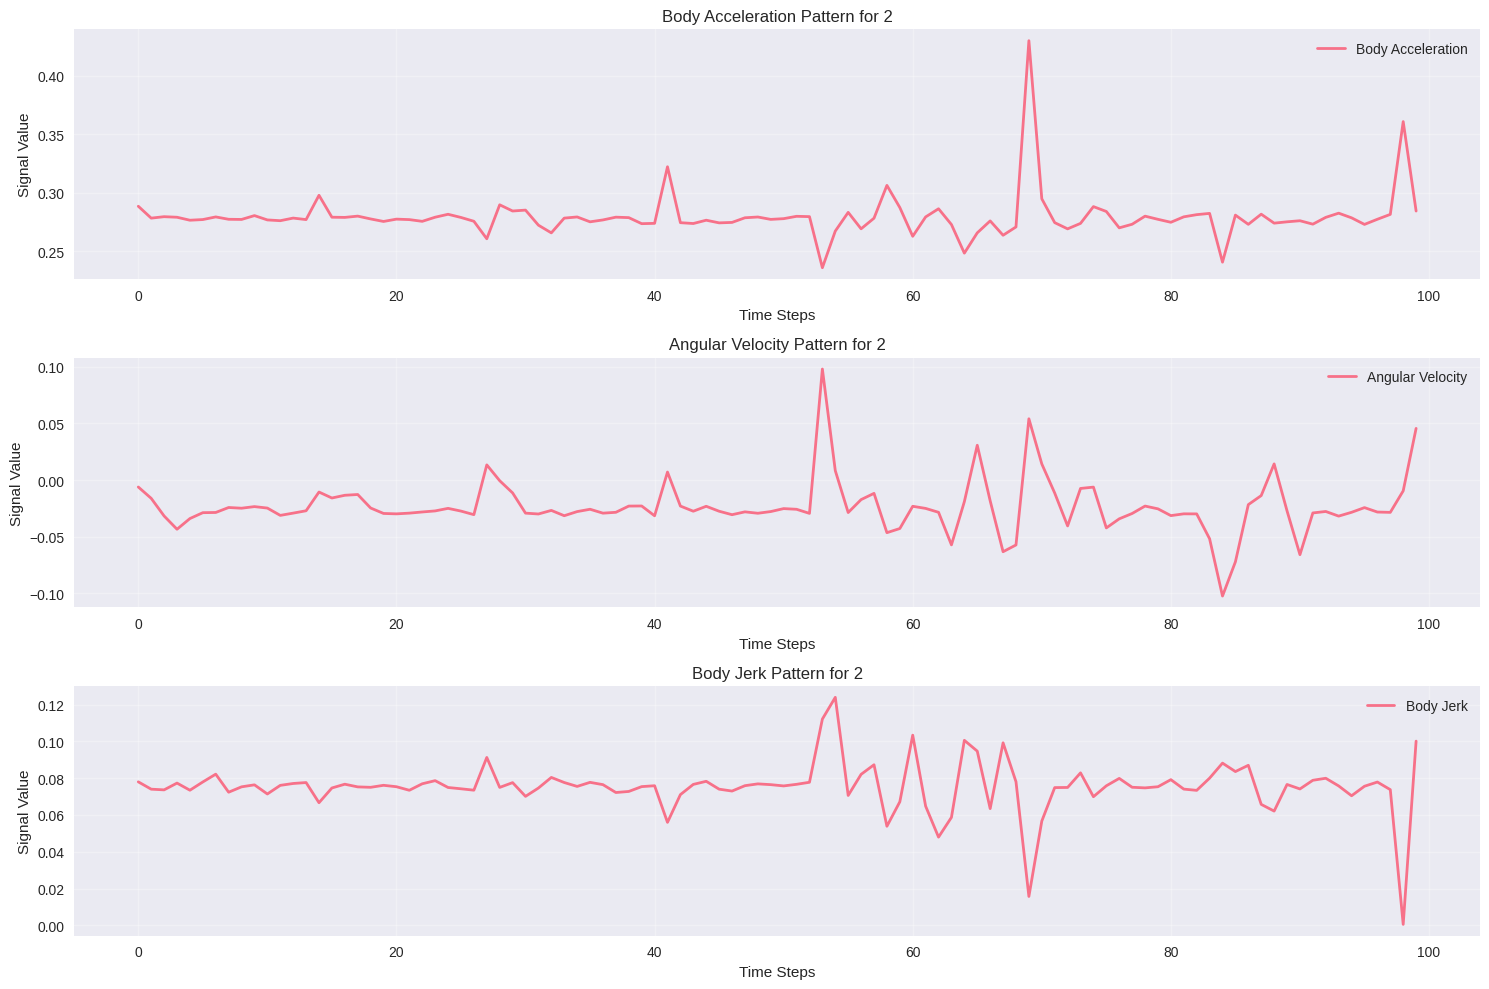


Signal Statistics:
|         |   Body Acceleration |   Angular Velocity |   Body Jerk |
|:--------|--------------------:|-------------------:|------------:|
| Mean    |               0.279 |             -0.026 |       0.075 |
| Std Dev |               0.02  |              0.026 |       0.011 |
| Max     |               0.632 |              0.316 |       0.138 |
| Min     |               0.111 |             -0.226 |      -0.031 |

Key Insights:
Body Acceleration:
- Variation: Low (std_dev: 0.020)
- Range: 0.520
Angular Velocity:
- Variation: Low (std_dev: 0.026)
- Range: 0.542
Body Jerk:
- Variation: Low (std_dev: 0.011)
- Range: 0.168

Analyzing signals for: 1


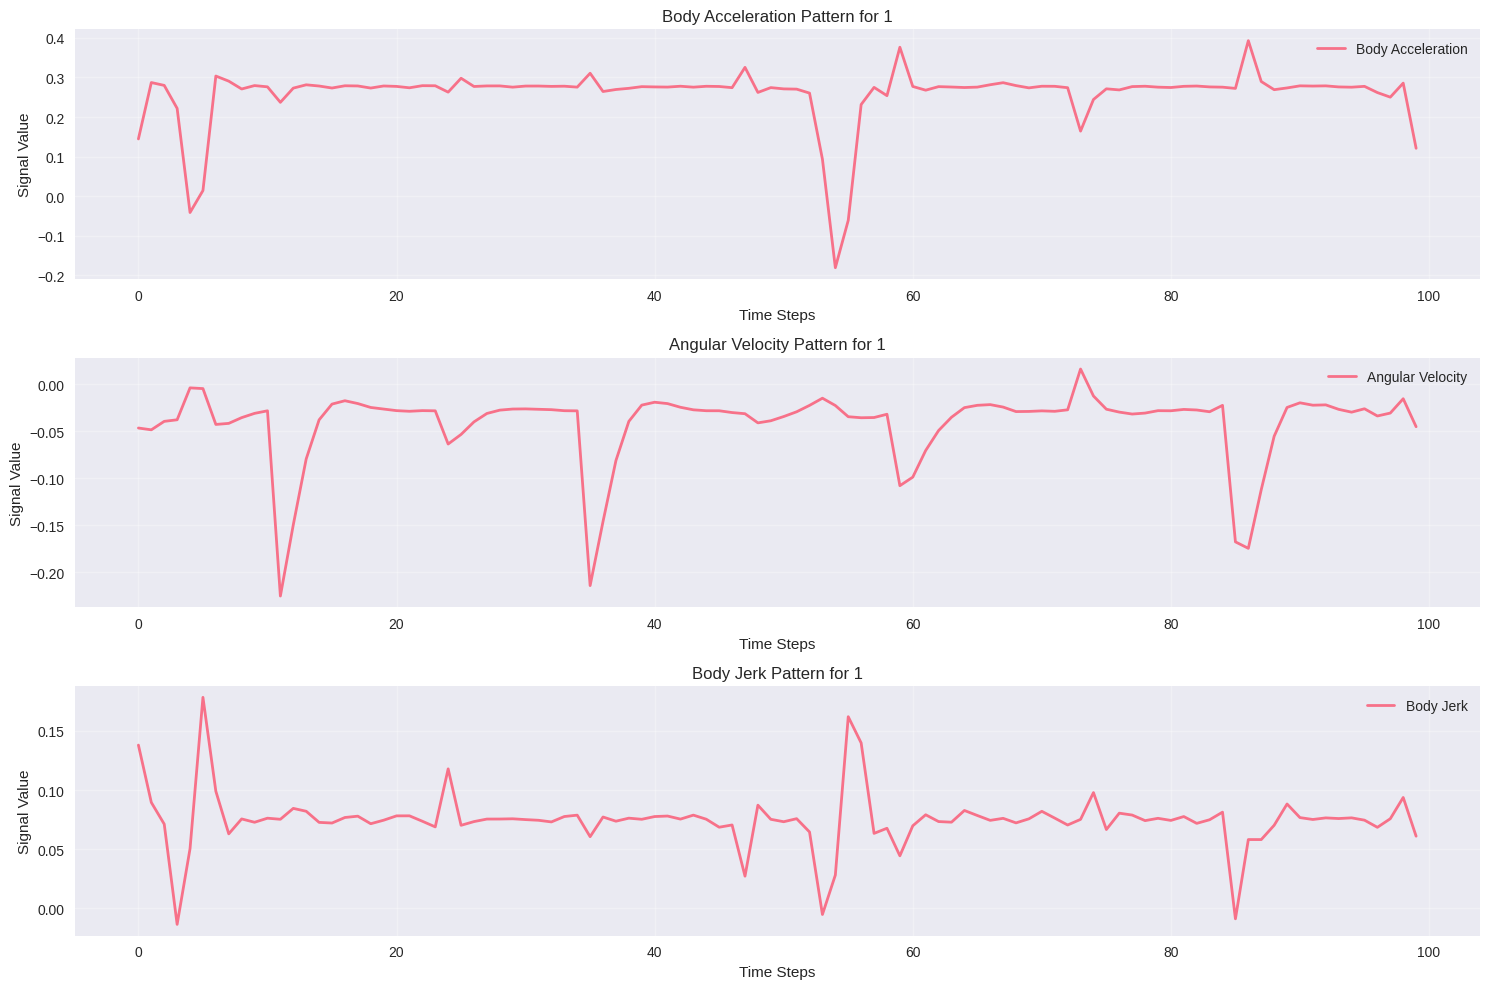


Signal Statistics:
|         |   Body Acceleration |   Angular Velocity |   Body Jerk |
|:--------|--------------------:|-------------------:|------------:|
| Mean    |               0.273 |             -0.038 |       0.076 |
| Std Dev |               0.042 |              0.044 |       0.021 |
| Max     |               0.559 |              0.184 |       0.309 |
| Min     |              -0.413 |             -0.349 |      -0.155 |

Key Insights:
Body Acceleration:
- Variation: Low (std_dev: 0.042)
- Range: 0.972
Angular Velocity:
- Variation: Low (std_dev: 0.044)
- Range: 0.533
Body Jerk:
- Variation: Low (std_dev: 0.021)
- Range: 0.464

Analyzing signals for: 0


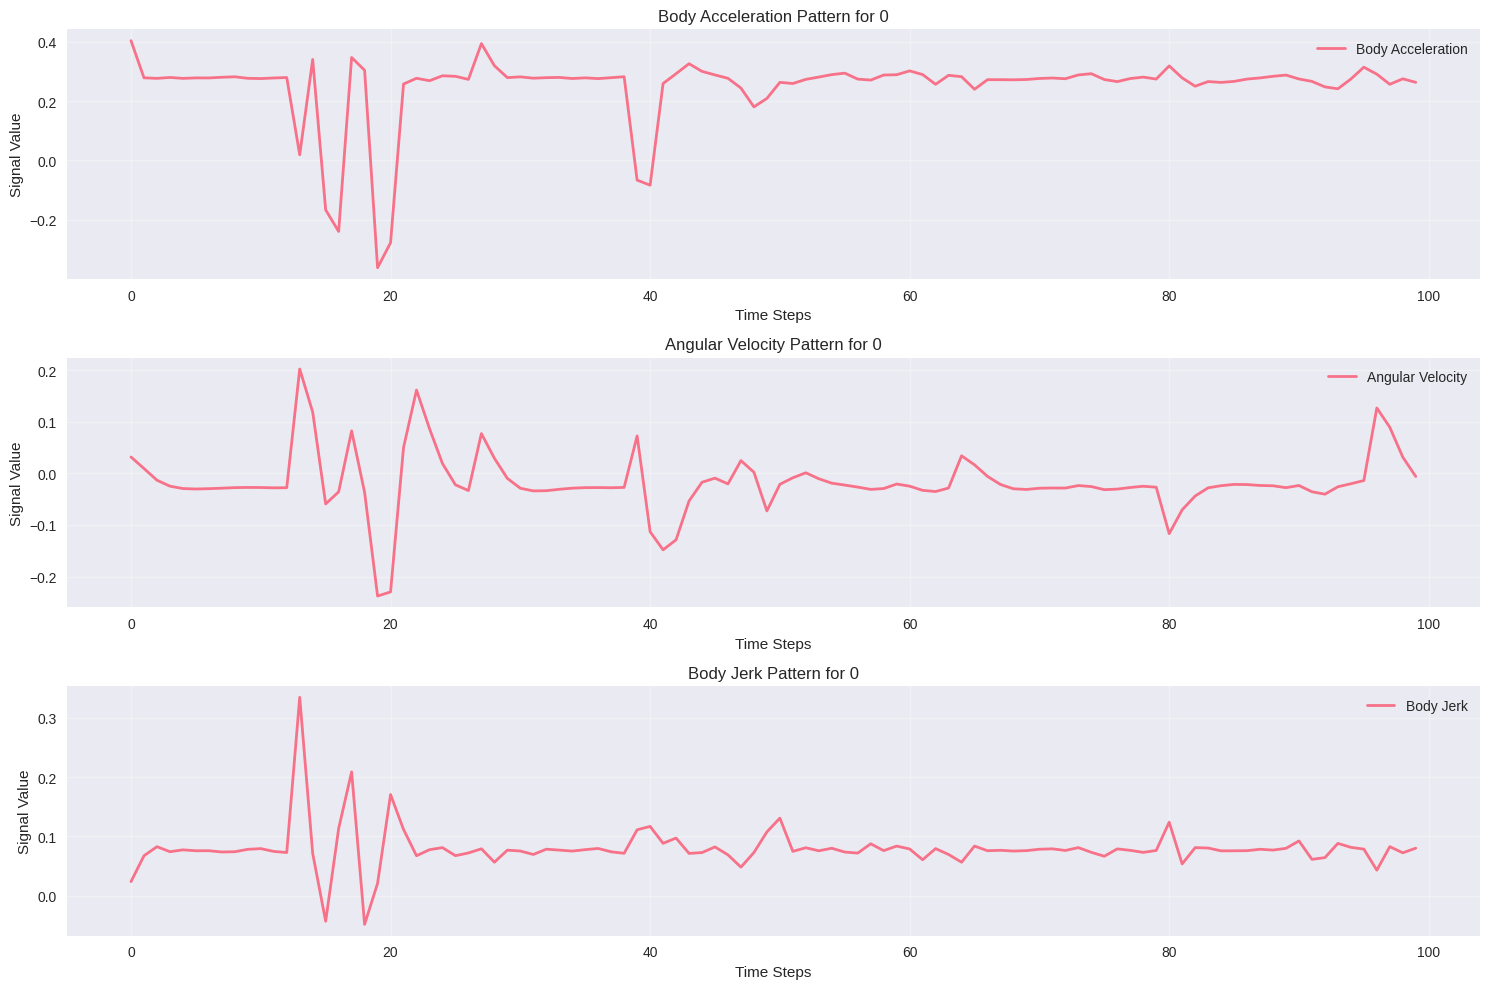


Signal Statistics:
|         |   Body Acceleration |   Angular Velocity |   Body Jerk |
|:--------|--------------------:|-------------------:|------------:|
| Mean    |               0.269 |             -0.017 |       0.082 |
| Std Dev |               0.102 |              0.06  |       0.049 |
| Max     |               1     |              0.524 |       0.638 |
| Min     |              -1     |             -0.453 |      -0.111 |

Key Insights:
Body Acceleration:
- Variation: High (std_dev: 0.102)
- Range: 2.000
Angular Velocity:
- Variation: Low (std_dev: 0.060)
- Range: 0.977
Body Jerk:
- Variation: Low (std_dev: 0.049)
- Range: 0.750

Analyzing signals for: 3


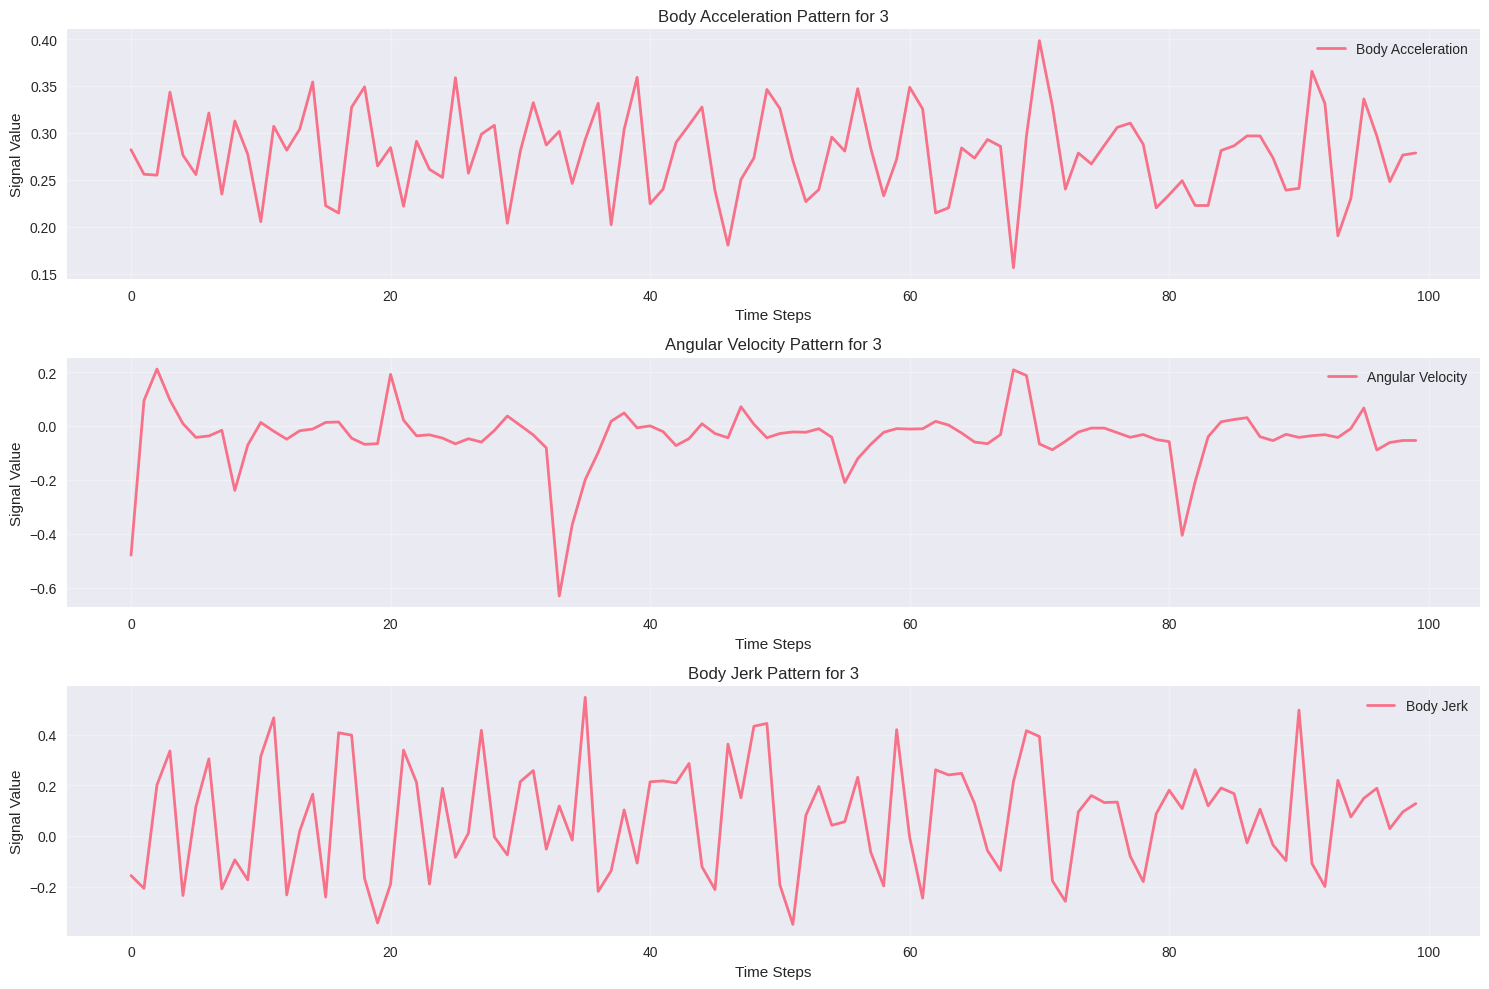


Signal Statistics:
|         |   Body Acceleration |   Angular Velocity |   Body Jerk |
|:--------|--------------------:|-------------------:|------------:|
| Mean    |               0.276 |             -0.031 |       0.078 |
| Std Dev |               0.05  |              0.128 |       0.219 |
| Max     |               0.433 |              0.489 |       0.761 |
| Min     |               0.121 |             -0.758 |      -0.541 |

Key Insights:
Body Acceleration:
- Variation: Low (std_dev: 0.050)
- Range: 0.312
Angular Velocity:
- Variation: High (std_dev: 0.128)
- Range: 1.246
Body Jerk:
- Variation: High (std_dev: 0.219)
- Range: 1.303

Analyzing signals for: 4


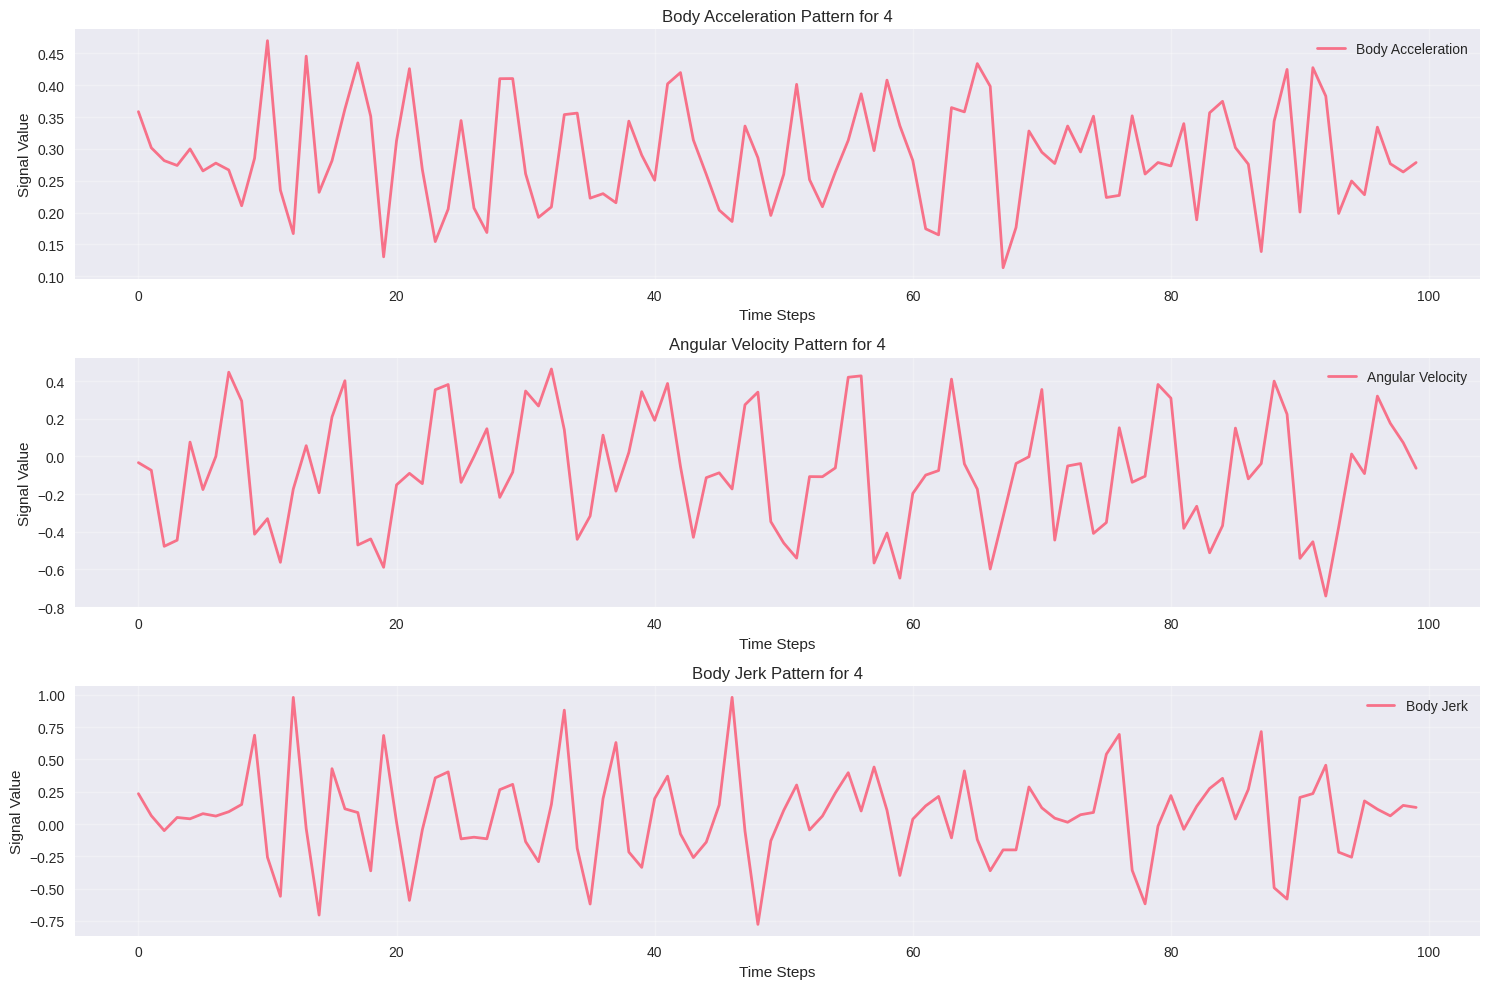


Signal Statistics:
|         |   Body Acceleration |   Angular Velocity |   Body Jerk |
|:--------|--------------------:|-------------------:|------------:|
| Mean    |               0.288 |             -0.077 |       0.088 |
| Std Dev |               0.095 |              0.324 |       0.349 |
| Max     |               0.618 |              0.739 |       1     |
| Min     |              -0.161 |             -0.914 |      -1     |

Key Insights:
Body Acceleration:
- Variation: Low (std_dev: 0.095)
- Range: 0.779
Angular Velocity:
- Variation: High (std_dev: 0.324)
- Range: 1.653
Body Jerk:
- Variation: High (std_dev: 0.349)
- Range: 2.000

Analyzing signals for: 5


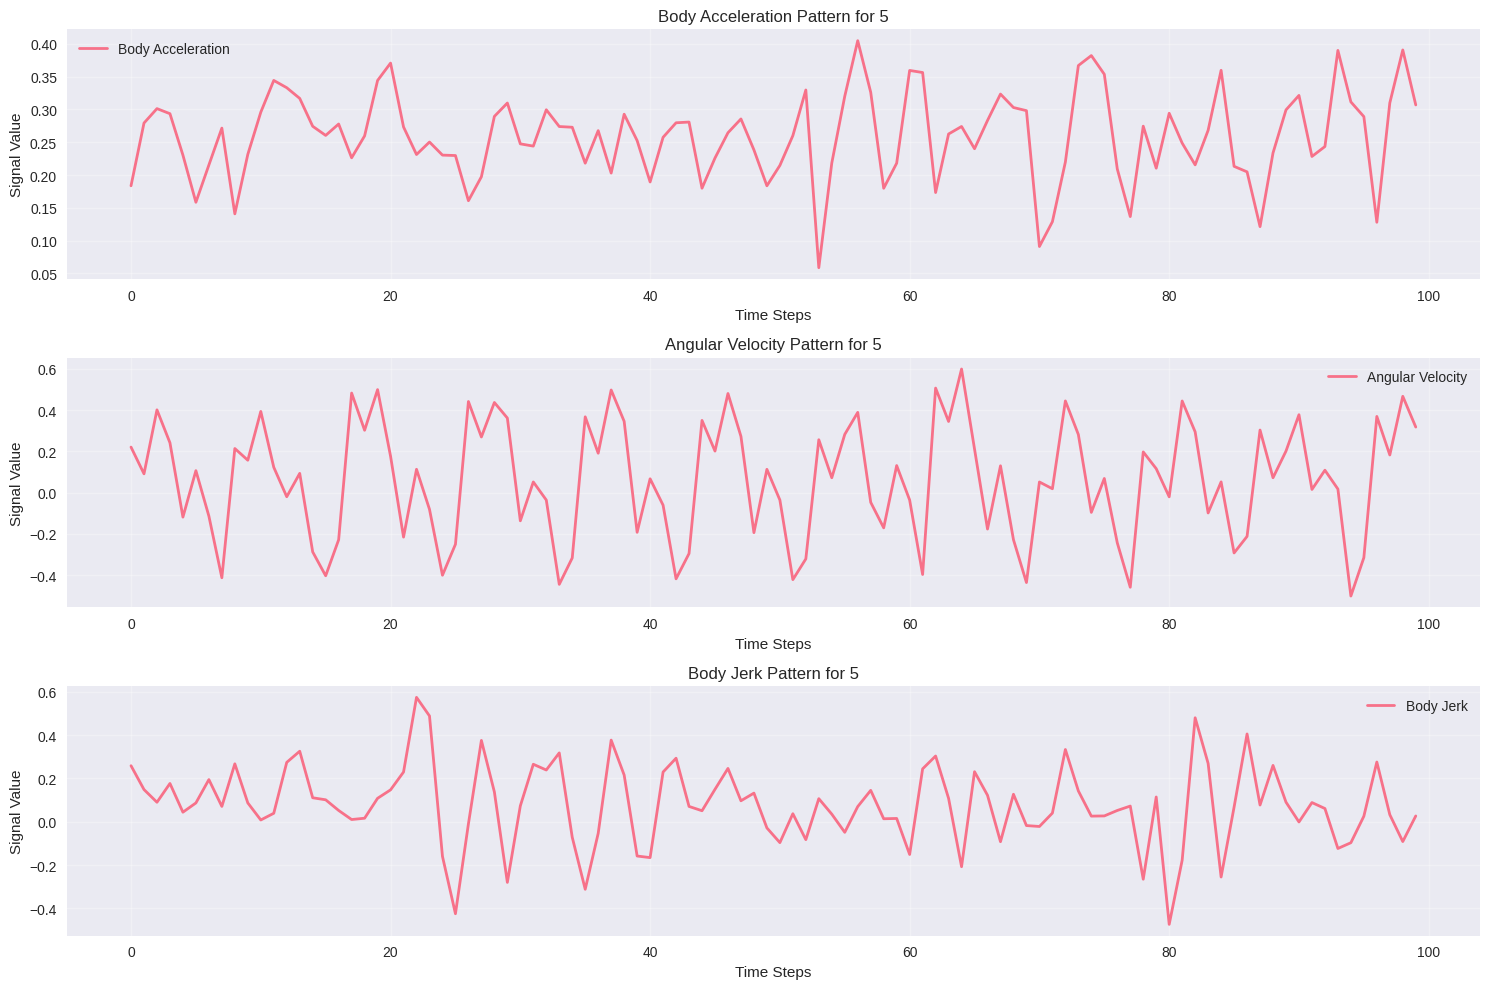


Signal Statistics:
|         |   Body Acceleration |   Angular Velocity |   Body Jerk |
|:--------|--------------------:|-------------------:|------------:|
| Mean    |               0.262 |              0.021 |       0.078 |
| Std Dev |               0.078 |              0.315 |       0.232 |
| Max     |               0.48  |              0.703 |       0.864 |
| Min     |              -0.061 |             -0.807 |      -0.555 |

Key Insights:
Body Acceleration:
- Variation: Low (std_dev: 0.078)
- Range: 0.541
Angular Velocity:
- Variation: High (std_dev: 0.315)
- Range: 1.510
Body Jerk:
- Variation: High (std_dev: 0.232)
- Range: 1.419

=== Activity Distribution Analysis ===

Activity Distribution:
|    |   Activity |   Training Samples |   Testing Samples |   Total |   Training % |   Testing % |
|---:|-----------:|-------------------:|------------------:|--------:|-------------:|------------:|
|  0 |          0 |               1407 |               537 |    1944 |        19.14 |     


Key Distribution Insights:
1. Most frequent activity: 0.0
2. Least frequent activity: 4.0
3. Average samples per activity: 1716.5
4. Distribution similarity between train/test: 0.960

=== Sensor Pattern Analysis ===

Analyzing Acceleration Patterns:

Mean Values:
|   Activity |   tBodyAcc-mean()-X |   tBodyAcc-mean()-Y |   tBodyAcc-mean()-Z |
|-----------:|--------------------:|--------------------:|--------------------:|
|          0 |               0.269 |              -0.018 |              -0.107 |
|          1 |               0.273 |              -0.012 |              -0.107 |
|          2 |               0.279 |              -0.016 |              -0.107 |
|          3 |               0.276 |              -0.018 |              -0.109 |
|          4 |               0.288 |              -0.016 |              -0.106 |
|          5 |               0.262 |              -0.027 |              -0.12  |

Standard Deviations:
|   Activity |   tBodyAcc-mean()-X |   tBodyAcc-mean()-Y |   tBod

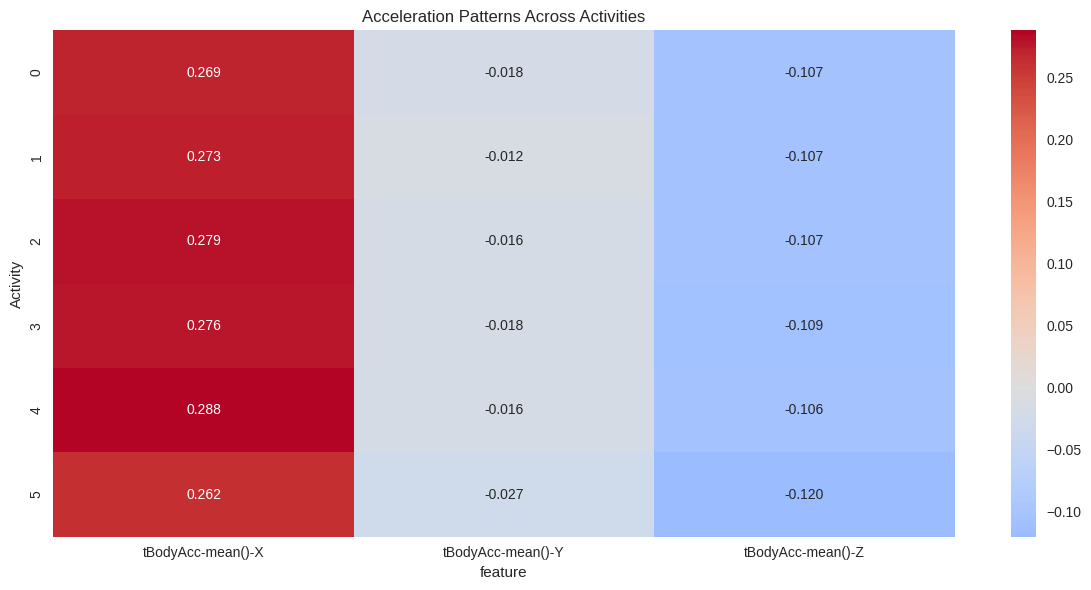


Key Insights:

0:
- Dominant axis: tBodyAcc-mean()-X (value: 0.269)
- Most variable: tBodyAcc-mean()-X (std: 0.102)

1:
- Dominant axis: tBodyAcc-mean()-X (value: 0.273)
- Most variable: tBodyAcc-mean()-Z (std: 0.045)

2:
- Dominant axis: tBodyAcc-mean()-X (value: 0.279)
- Most variable: tBodyAcc-mean()-Z (std: 0.036)

3:
- Dominant axis: tBodyAcc-mean()-X (value: 0.276)
- Most variable: tBodyAcc-mean()-X (std: 0.050)

4:
- Dominant axis: tBodyAcc-mean()-X (value: 0.288)
- Most variable: tBodyAcc-mean()-X (std: 0.095)

5:
- Dominant axis: tBodyAcc-mean()-X (value: 0.262)
- Most variable: tBodyAcc-mean()-X (std: 0.078)

Analyzing Gyroscope Patterns:

Mean Values:
|   Activity |   tBodyGyro-mean()-X |   tBodyGyro-mean()-Y |   tBodyGyro-mean()-Z |
|-----------:|---------------------:|---------------------:|---------------------:|
|          0 |               -0.017 |               -0.092 |                0.127 |
|          1 |               -0.038 |               -0.073 |                

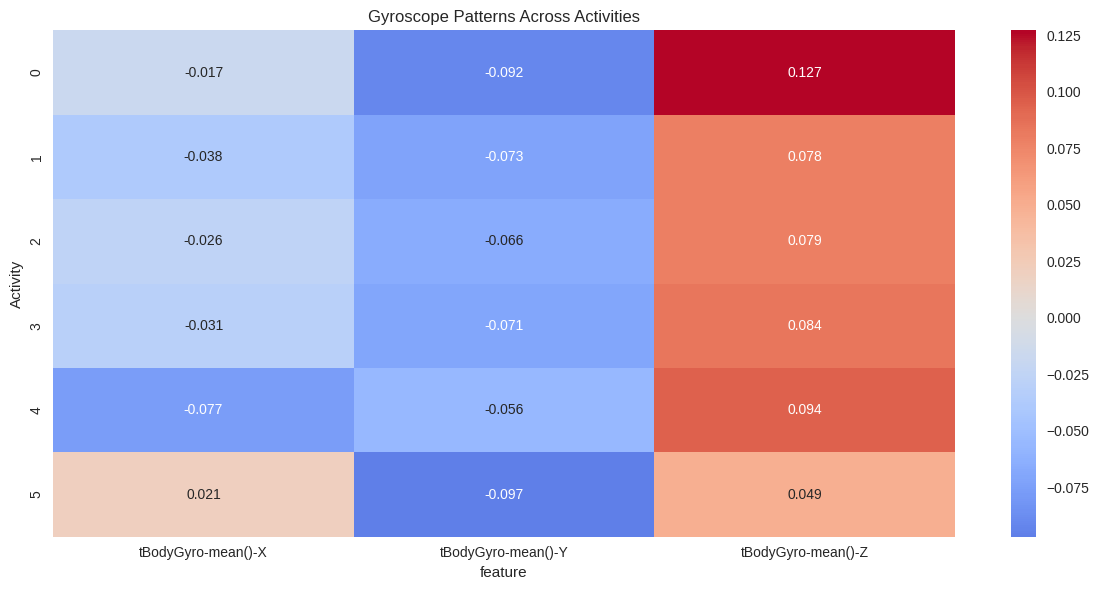


Key Insights:

0:
- Dominant axis: tBodyGyro-mean()-Z (value: 0.127)
- Most variable: tBodyGyro-mean()-Z (std: 0.143)

1:
- Dominant axis: tBodyGyro-mean()-Z (value: 0.078)
- Most variable: tBodyGyro-mean()-Z (std: 0.129)

2:
- Dominant axis: tBodyGyro-mean()-Z (value: 0.079)
- Most variable: tBodyGyro-mean()-Y (std: 0.058)

3:
- Dominant axis: tBodyGyro-mean()-Z (value: 0.084)
- Most variable: tBodyGyro-mean()-X (std: 0.128)

4:
- Dominant axis: tBodyGyro-mean()-Z (value: 0.094)
- Most variable: tBodyGyro-mean()-X (std: 0.324)

5:
- Dominant axis: tBodyGyro-mean()-Y (value: 0.049)
- Most variable: tBodyGyro-mean()-X (std: 0.315)

Analyzing Jerk Patterns:

Mean Values:
|   Activity |   tBodyAccJerk-mean()-X |   tBodyAccJerk-mean()-Y |   tBodyAccJerk-mean()-Z |
|-----------:|------------------------:|------------------------:|------------------------:|
|          0 |                   0.082 |                   0.011 |                  -0.005 |
|          1 |                   0.076 |  

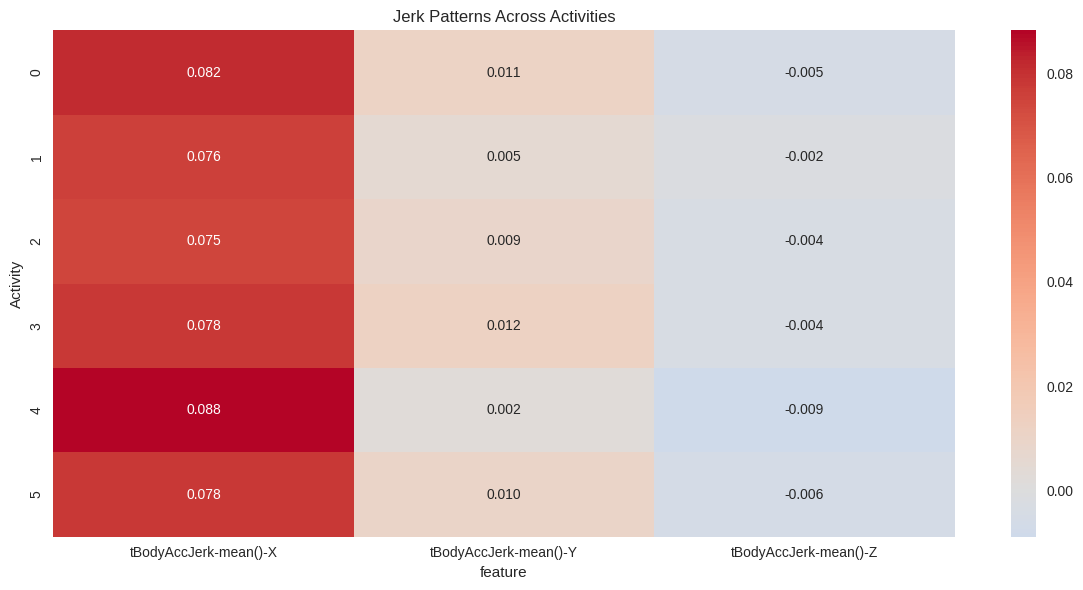


Key Insights:

0:
- Dominant axis: tBodyAccJerk-mean()-X (value: 0.082)
- Most variable: tBodyAccJerk-mean()-Z (std: 0.073)

1:
- Dominant axis: tBodyAccJerk-mean()-X (value: 0.076)
- Most variable: tBodyAccJerk-mean()-Y (std: 0.064)

2:
- Dominant axis: tBodyAccJerk-mean()-X (value: 0.075)
- Most variable: tBodyAccJerk-mean()-Z (std: 0.045)

3:
- Dominant axis: tBodyAccJerk-mean()-X (value: 0.078)
- Most variable: tBodyAccJerk-mean()-Y (std: 0.242)

4:
- Dominant axis: tBodyAccJerk-mean()-X (value: 0.088)
- Most variable: tBodyAccJerk-mean()-X (std: 0.349)

5:
- Dominant axis: tBodyAccJerk-mean()-X (value: 0.078)
- Most variable: tBodyAccJerk-mean()-X (std: 0.232)

=== HAR Dataset Analysis Summary ===

1. Dataset Overview:
- Total features: 561
- Time domain features: 265
- Frequency domain features: 289
- Number of activities: 6
- Total samples: 7352

2. Activity Patterns Summary:

2:
- Movement intensity: Low
- Rotation variation: Low

1:
- Movement intensity: Low
- Rotation variat

In [ ]:
# Cell 9: Create Analyzer and Run Analysis
# Create analyzer instance with raw and processed data
analyzer = HARAnalyzer(
    raw_data={'X_train': X_train, 'X_test': X_test,
              'y_train': y_train, 'y_test': y_test},
    processed_data={'X_train_windows': X_train_windows,
                   'X_test_windows': X_test_windows,
                   'y_train_windows': y_train_windows,
                   'y_test_windows': y_test_windows}
)

# Run analyses
analyzer.visualize_activity_signals()
analyzer.analyze_activity_distribution()
analyzer.analyze_sensor_patterns()
analyzer.generate_final_summary()